# Correct PINNs Prediction with FEM and $\phi$-FEM

Maillage standard créé avec la levelset + interpolation solution sur maillage surraffinée

In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
from scar.problem.Case import *
from scar.equations.Poisson2D import *
from scar.utils import read_config,create_tree
from scar.equations.run_Poisson2D import *

from scar.solver.solver_fem import *
from scar.solver.solver_phifem import *
from scar.correction.correct_pred import *

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


Using device: cuda
cuda devices:        1
cuda current device: 0
cuda device name:    NVIDIA RTX 2000 Ada Generation Laptop GPU
torch loaded; device is cuda
torch loaded; device is cuda


## Define case

bc_points.shape = (2000, 2), bc_normals.shape = (2000, 2)
ICIIIII : tv_loss_f =  MSELoss()
>> load network /home/flecourtier/Bureau/Thèse/networks/EikonalLap2D/Bean/models/model_3.pth
norm_grad_norm_gradu : torch.Size([20000, 1])
norm_grad_norm_gradu : torch.Size([20000, 1])


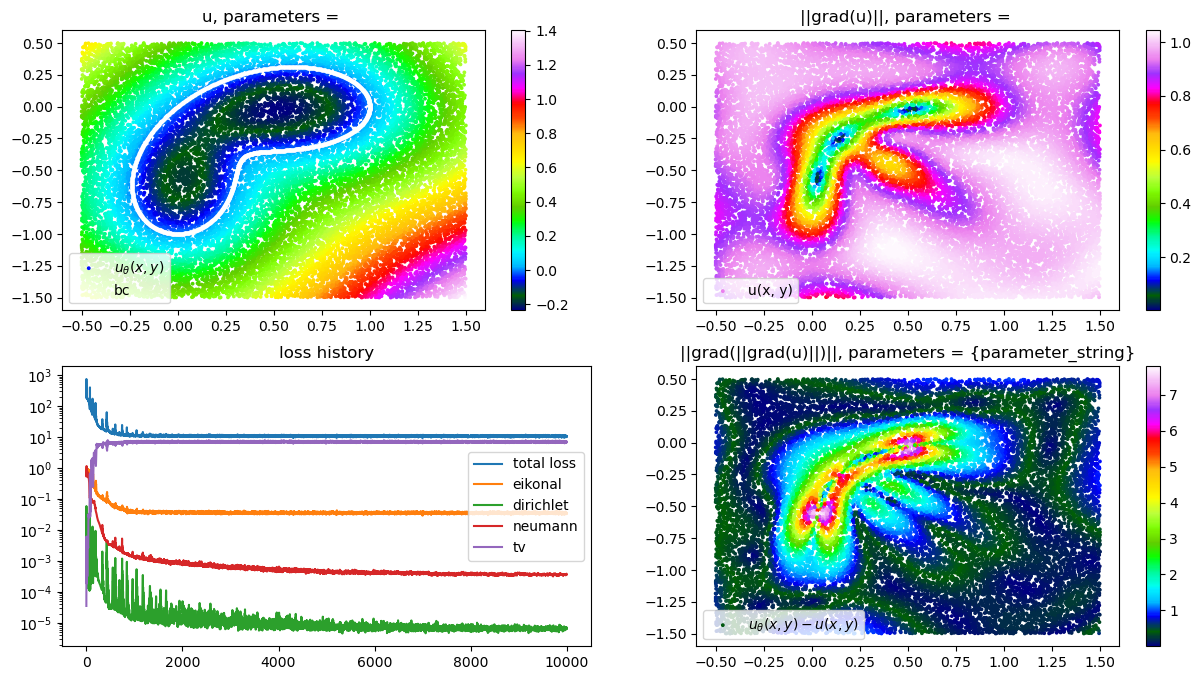

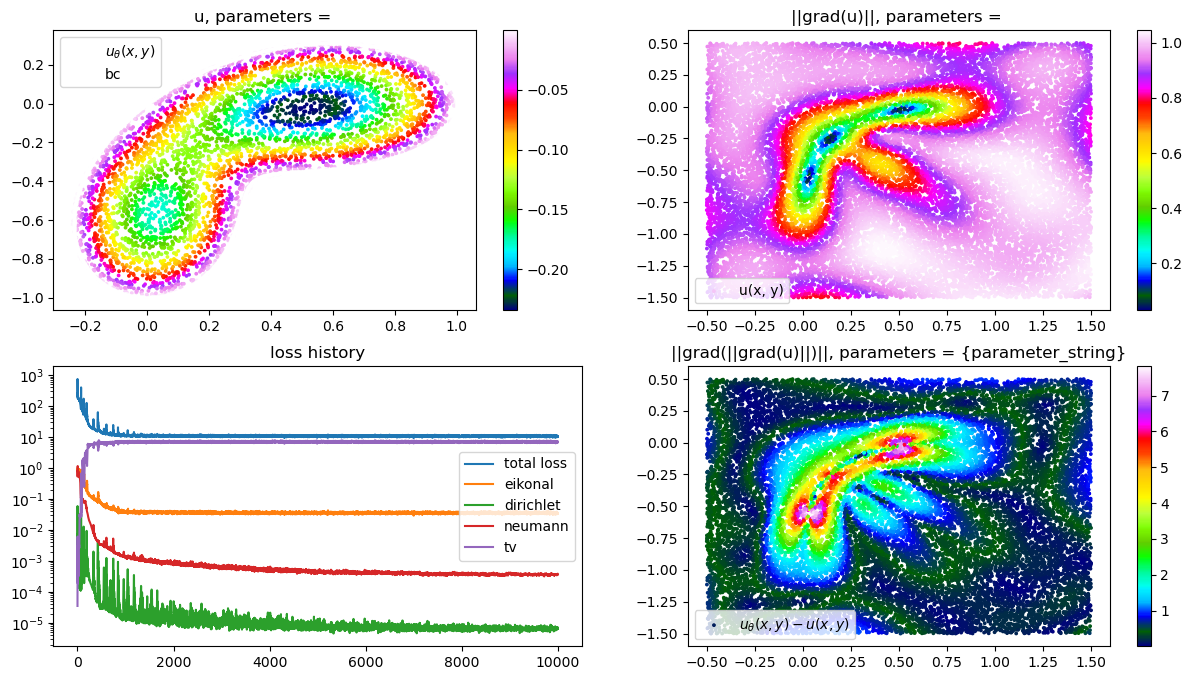

In [3]:
config = 1
casefile = "../../testcases/"+"lap_bean_3.json"
casefile_dict = read_config(casefile)

cas = Case(casefile)
problem_considered = cas.problem
pde_considered = cas.pde
type = 0 # help="0 - all ; 1 - add ; 2 - add IPP ; 3 - mult"

dir_name = "../../"+cas.dir_name
models_dir = dir_name+"models/"
corr_type = cas.corr_type
corr_dir = "../../"+cas.corr_dir_name
create_tree(corr_dir)

## Récupération du modèle

### Config file :  ../../networks/Poisson2D/Bean/SDEikonalLap/ConstantForce/form_3/0.0/models/config_1.json
### Model file :  ../../networks/Poisson2D/Bean/SDEikonalLap/ConstantForce/form_3/0.0/models/model_1.pth
### Config  1  :  {'layers': [20, 20, 20, 20], 'activation': 'sine', 'lr': 0.01, 'decay': 0.99, 'w_data': 0.0, 'w_res': 1.0, 'n_epochs': 10000, 'n_collocations': 2000, 'n_data': 0}
Threshold of the sampling:  0.0
Threshold of the sampling:  0.0
Threshold of the sampling:  0.0
Threshold of the sampling:  0.0
>> load network /home/flecourtier/Bureau/Thèse/networks/Poisson2D/Bean/SDEikonalLap/ConstantForce/form_3/0.0/models/model_1.pth


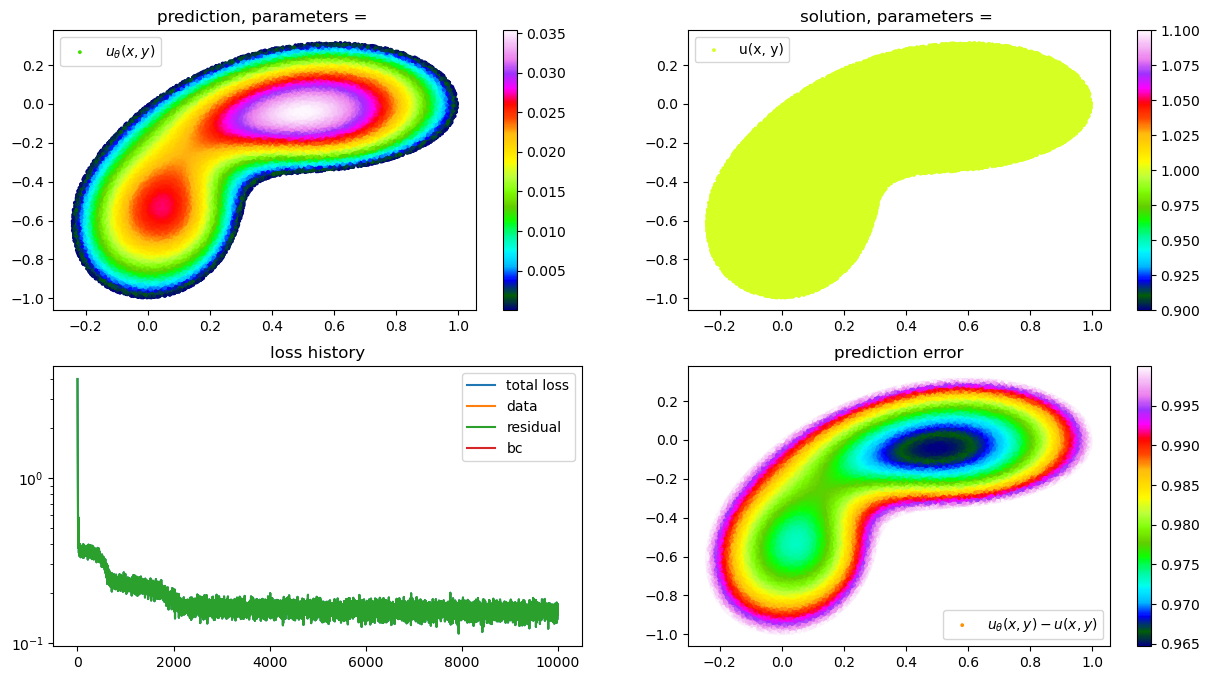

In [4]:
config_filename = models_dir+"config_"+str(config)+".json"
model_filename = models_dir+"model_"+str(config)+".pth"
print("### Config file : ",config_filename)
print("### Model file : ",model_filename)

dict = read_config(config_filename)
print("### Config ", config, " : ", dict)

trainer = run_Poisson2D(cas,config,dict)

In [5]:
eik = cas.sd_function.eik_pinns
form_trainer = cas.sd_function.form_trainer

## Correction

In [6]:
if trainer.pde.nb_parameters == 0:
    params = [[None,None,None]]
else:
    mu = torch.mean(trainer.pde.parameter_domain, axis=1)
    S,f,p = mu.numpy()
    params = [[S,f,p]]

nb_vert = 32
deg_corr = 10

### Avec FEM

In [8]:
solver = FEMSolver(nb_cell=nb_vert-1, params=params, cas=cas)

# get differents solutions
analytical = problem_considered.analytical_sol
if analytical:
    u_ex = UexExpr(params[0], degree=10, domain=solver.mesh, pb_considered=solver.pb_considered)
    u_PINNs, norm_L2_PINNs = get_u_PINNs(trainer,solver,deg_corr,get_error=True,analytical_sol=analytical)
    u_Corr,C,norm_L2_Corr = correct_pred(solver,u_PINNs,corr_type,analytical_sol=analytical)
    u_FEM,norm_L2_FEM = solver.fem(0,analytical_sol=analytical)
else:
    mesh_dir = dir_name + "meshes/"
    mesh_ex,V_ex,u_ex = problem_considered.u_ref(form_trainer,mesh_dir)

    print("Get u_PINNs")

    u_PINNs, _ = get_u_PINNs(trainer,solver,deg_corr,get_error=False,analytical_sol=analytical)
    # u_PINNs_inter = interpolate(u_PINNs, V_ex)
    norm_L2_PINNs = (assemble((((u_ex - u_PINNs)) ** 2) * solver.dx) ** (0.5)) / (assemble((((u_ex)) ** 2) * solver.dx) ** (0.5))
    
    print("Get u_Corr")

    u_Corr,C,_ = correct_pred(solver,u_PINNs,corr_type,get_error=False,analytical_sol=analytical)
    u_Corr_inter = project(u_Corr, solver.V)
    u_Corr_inter = interpolate(u_Corr_inter, V_ex)
    norm_L2_Corr = (assemble((((u_ex - u_Corr_inter)) ** 2) * solver.dx) ** (0.5)) / (assemble((((u_ex)) ** 2) * solver.dx) ** (0.5))

    print("Get u_FEM")

    u_FEM,_ = solver.fem(0,get_error=False,analytical_sol=analytical)
    u_FEM_inter = interpolate(u_FEM, V_ex)
    norm_L2_FEM = (assemble((((u_ex - u_FEM_inter)) ** 2) * solver.dx) ** (0.5)) / (assemble((((u_ex)) ** 2) * solver.dx) ** (0.5))

Reading new mesh from file
Building point search tree to accelerate distance queries.
Computed bounding box tree with 40903 nodes for 20452 points.
Get u_Corr
Building point search tree to accelerate distance queries.
Computed bounding box tree with 665 nodes for 333 points.
Get u_FEM


Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.


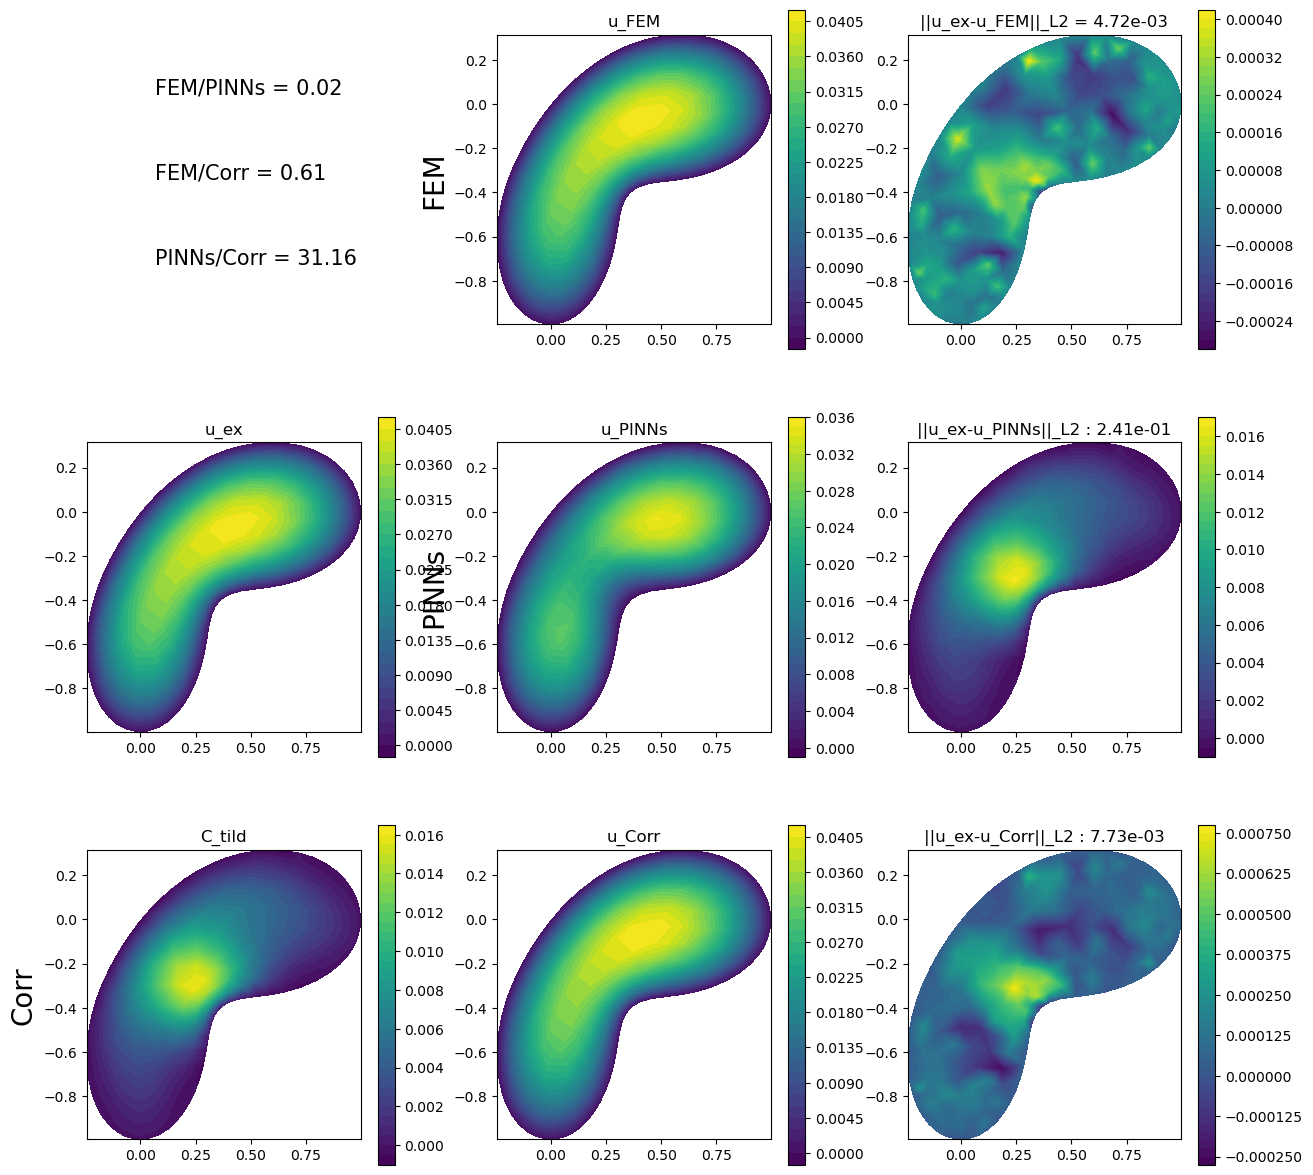

In [9]:
u_ex = interpolate(u_ex, solver.V)

solutions = [u_PINNs,u_Corr_inter,u_FEM_inter]
normes = [norm_L2_PINNs,norm_L2_Corr,norm_L2_FEM]

plot_sol(corr_dir,config,"FEM",u_ex,C,solutions,normes,solver.V)

### Avec PhiFEM

In [10]:
solver = PhiFemSolver(nb_cell=nb_vert-1, params=params, cas=cas)

# get differents solutions
analytical = problem_considered.analytical_sol
if analytical:
    u_ex = UexExpr(params[0], degree=10, domain=solver.mesh, pb_considered=solver.pb_considered)
    u_PINNs, norm_L2_PINNs = get_u_PINNs(trainer,solver,deg_corr,get_error=True,analytical_sol=analytical)
    u_Corr,C,norm_L2_Corr = correct_pred(solver,u_PINNs,corr_type,analytical_sol=analytical)
    u_FEM,norm_L2_FEM = solver.fem(0,analytical_sol=analytical)
else:
    mesh_dir = dir_name + "meshes/"
    mesh_ex,V_ex,u_ex = problem_considered.u_ref(form_trainer,mesh_dir)

    # print("Get u_PINNs")

    u_PINNs, _ = get_u_PINNs(trainer,solver,deg_corr,get_error=False,analytical_sol=analytical)
    # u_PINNs_inter = interpolate(u_PINNs_inter, V_ex)
    norm_L2_PINNs = (assemble((((u_ex - u_PINNs)) ** 2) * solver.dx) ** (0.5)) / (assemble((((u_ex)) ** 2) * solver.dx) ** (0.5))
    
    print("Get u_Corr")

    u_Corr,C,_ = correct_pred(solver,u_PINNs,corr_type,get_error=False,analytical_sol=analytical)
    u_Corr_inter = project(u_Corr, solver.V)
    u_Corr_inter = interpolate(u_Corr_inter, V_ex)
    norm_L2_Corr = (assemble((((u_ex - u_Corr_inter)) ** 2) * solver.dx) ** (0.5)) / (assemble((((u_ex)) ** 2) * solver.dx) ** (0.5))

    print("Get u_FEM")

    u_FEM,_ = solver.fem(0,get_error=False,analytical_sol=analytical)
    u_FEM_inter = interpolate(u_FEM, V_ex)
    norm_L2_FEM = (assemble((((u_ex - u_FEM_inter)) ** 2) * solver.dx) ** (0.5)) / (assemble((((u_ex)) ** 2) * solver.dx) ** (0.5))

# # get differents solutions
# analytical = problem_considered.analytical_sol
# if analytical:
#     u_ex = UexExpr(params[0], degree=10, domain=solver.mesh, pb_considered=solver.pb_considered)
# else:
#     u_ex = problem_considered.u_ref()
# u_PINNs, norm_L2_PINNs = get_u_PINNs(trainer,solver,deg_corr, get_error=True,analytical_sol=analytical)
# print("u_PINNs : ",norm_L2_PINNs)
# u_Corr,C,norm_L2_Corr = correct_pred(solver,u_PINNs,corr_type,analytical_sol=analytical)
# print("u_Corr : ",norm_L2_Corr)
# u_FEM,norm_L2_FEM = solver.fem(0,analytical_sol=analytical)
# print("u_FEM : ",norm_L2_FEM)

num of cell in the ghost penalty: 124
Reading new mesh from file


/home/flecourtier/Bureau/Thèse/src/scar/geometry/Geometry2D.py:154: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1702400441250/work/torch/csrc/utils/tensor_new.cpp:261.)
  return self.R()@torch.Tensor([x,y])


Building point search tree to accelerate distance queries.
Get u_Corr
Computed bounding box tree with 40903 nodes for 20452 points.


TypeError: corr_add() got an unexpected keyword argument 'get_error'

Building point search tree to accelerate distance queries.
Computed bounding box tree with 14569 nodes for 7285 points.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.


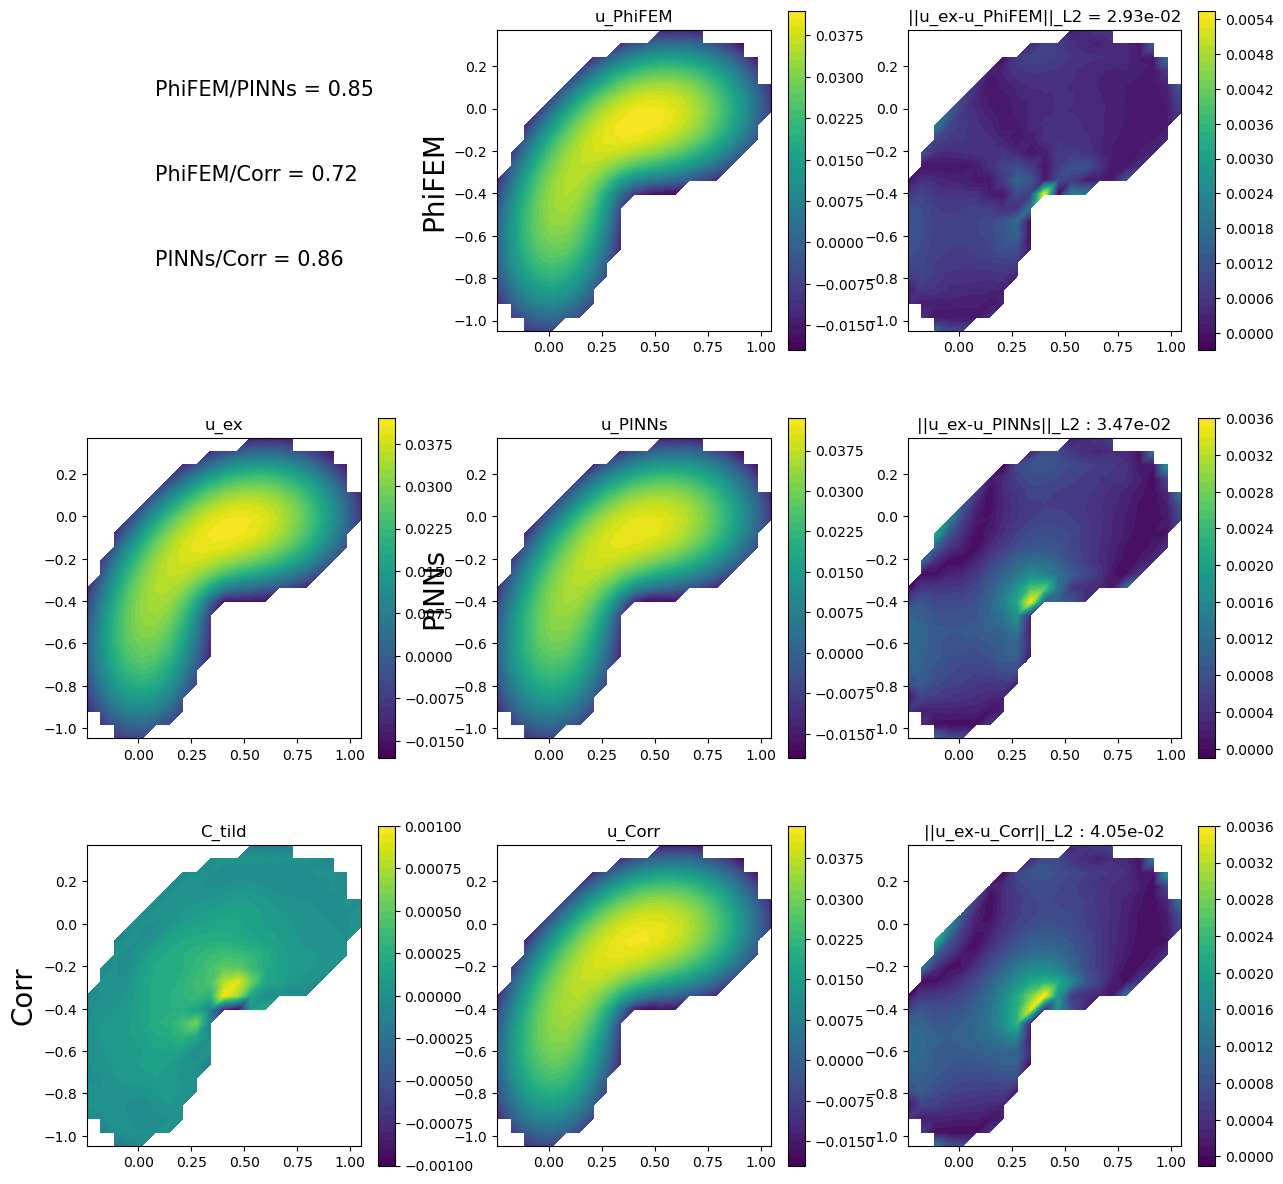

In [ ]:
# plot
u_ex = project(u_ex, solver.V)

solutions = [u_PINNs,u_Corr,u_FEM]
normes = [norm_L2_PINNs,norm_L2_Corr,norm_L2_FEM]

plot_sol(corr_dir,config,"PhiFEM",u_ex,C,solutions,normes,solver.V)

Projection sur $\Omega$ :

Building point search tree to accelerate distance queries.
Computed bounding box tree with 973 nodes for 487 points.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.


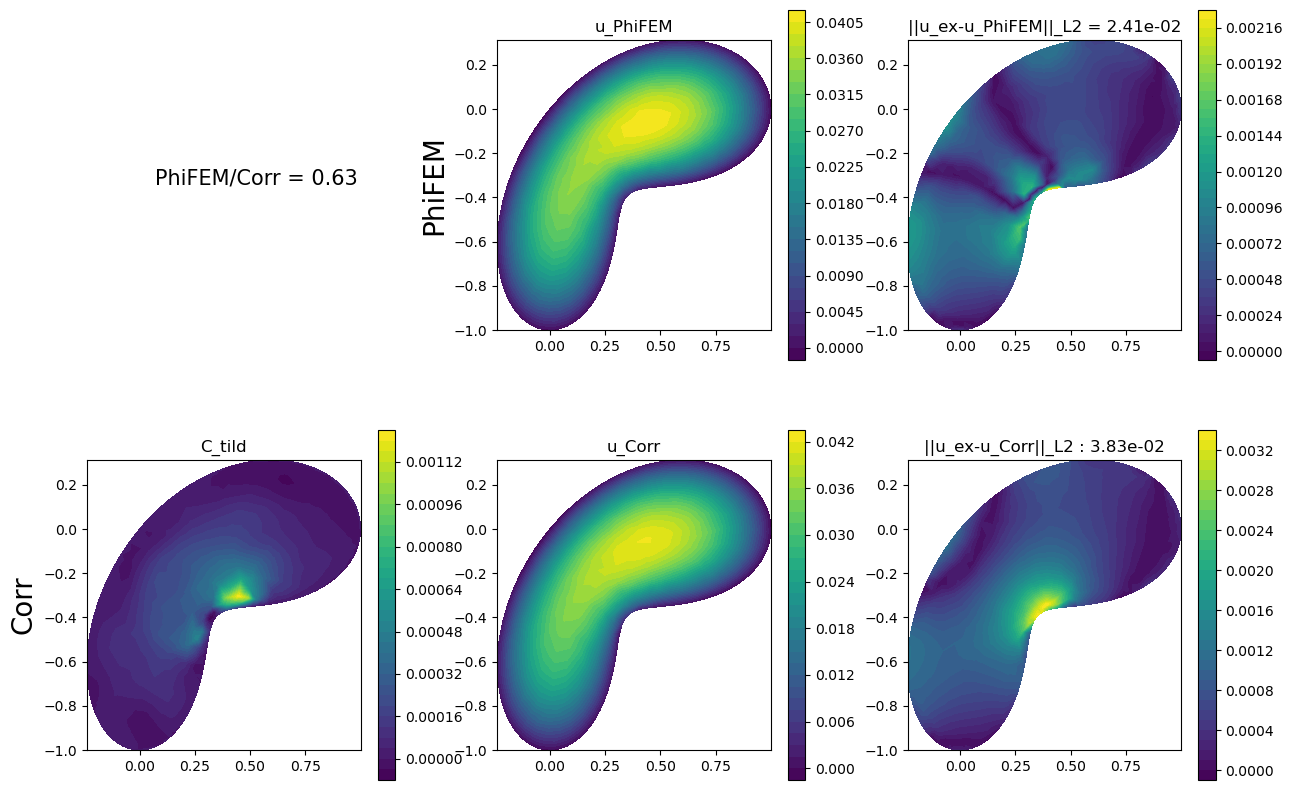

In [ ]:
# project u_ex on Omega
u_ex_Omega = project(u_ex, solver.V_ex)

# project u_Corr on Omega
u_Corr_ = project(u_Corr, solver.V)
u_Corr_Omega = project(u_Corr_, solver.V_ex)    
norm_L2_Corr_Omega = (assemble((((u_ex_Omega - u_Corr_Omega)) ** 2) * solver.dx_ex) ** (0.5)) / (assemble((((u_ex_Omega)) ** 2) * solver.dx_ex) ** (0.5))

# project u_FEM on Omega
u_FEM_ = project(u_FEM, solver.V)
u_FEM_Omega = project(u_FEM_, solver.V_ex)

norm_L2_FEM_Omega = (assemble((((u_ex_Omega - u_FEM_Omega)) ** 2) * solver.dx_ex) ** (0.5)) / (assemble((((u_ex_Omega)) ** 2) * solver.dx_ex) ** (0.5))


#####
# Plot !
#####

solutions = [u_Corr_Omega,u_FEM_Omega]
normes = [norm_L2_Corr_Omega,norm_L2_FEM_Omega]
# plot_sol(corr_type,"PhiFEM",u_ex_Omega,solutions,normes,solver.V_ex,project_on_Omega=True)
plot_sol(corr_dir,config,"PhiFEM",u_ex_Omega,C,solutions,normes,solver.V_ex,project_on_Omega=True)